# TODO
- 結果の可視化
    - 複数イメージによるgifもしくはmp4の作成
    - 参考: [matplotlibで簡単にアニメーションを作る](https://qiita.com/msrks/items/e264872efa062c7d6955)
- 様々な初期条件の設定による電磁界のシミュレーション
    - 導波管の進み
    - アレイアンテナによるビーム形成
- 吸収境界条件
- 電磁界の3次元化

In [1]:
%matplotlib notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D

from tqdm import tqdm 


plt.style.use("dark_background")

# Physical Constant

In [2]:
permittivity_of_vacuum = 8.85419e-12
permeability_of_vacuum = 1.25664e-06
c = 1/ np.sqrt( permeability_of_vacuum * permittivity_of_vacuum)

## setup

In [33]:
# %%time
# set 
t = 0
dt = 1e-10
nt= 1000 # 1000
f = 1 * 1e8
amplitude = 0.1

ndim = 2 # TE wave
Nx = Ny = 40
dx = dy = 0.1



# set field properties
conductivity = 0 * np.ones((Nx, Ny, 1))
permittivity = permittivity_of_vacuum * np.ones((Nx, Ny, 1))
permeability = permeability_of_vacuum * np.ones((Nx, Ny, 1))


coeff1 = conductivity * dt / (2 * permittivity)
c_ez = (1 - coeff1) / (1 + coeff1) 
c_ezlx = dt/(permittivity * dx * (1 + coeff1))
c_ezly = dt/(permittivity * dy * (1 + coeff1))
c_ezj = dt/(permittivity  * (1 + coeff1))

c_hxlx = dt/(permeability * dx)
c_hxly = dt/(permeability * dy)

e_field = np.zeros((Nx, Ny, 1)) # only z direction
h_field = np.zeros((Nx, Ny, 2)) # x and y direction

# time domain result array
t_arr  = np.arange(nt) * dt
ez_result = np.zeros((t_arr.shape[0], Nx, Ny, 1))
jz_t = np.zeros((t_arr.shape[0], Nx, Ny, 1))

wave_length = c / f
z0 = np.sqrt(permeability_of_vacuum/permittivity_of_vacuum)
c = 1/ np.sqrt( permeability_of_vacuum * permittivity_of_vacuum)
print("check Courant Condition", 1/(np.sqrt((1/dx)**2 + (1/dy)**2)) >c * dt)
print("wave_length : {}[m], x_limit : {}[m], y_limit : {}[m], dx : {}[m], dy : {}[m]".format(wave_length, Nx*dx, Ny*dy, dx, dy))

e_field = np.zeros((Nx, Ny, 1)) # only z direction
h_field = np.zeros((Nx, Ny, 2)) # x and y direction


check Courant Condition True
wave_length : 2.9979207053166466[m], x_limit : 4.0[m], y_limit : 4.0[m], dx : 0.1[m], dy : 0.1[m]


## Set Initial Field

In [34]:
# pulse Current Source
j_amp = 0.01 # cez_j = 11
one_cycle_end_index = int(1 / f / dt)
j_val =  j_amp * np.sin(2 * np.pi * f  * t_arr[:one_cycle_end_index])

source_xpos = int(Nx/2)
source_ypos = int(Ny/2)
jz_t[:one_cycle_end_index, source_xpos, source_ypos,0] = j_val
'''
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(t_arr[:one_cycle_end_index], j_val)
fig.show()
'''

'\nfig = plt.figure()\nax = fig.add_subplot(111)\nax.plot(t_arr[:one_cycle_end_index], j_val)\nfig.show()\n'

In [6]:
def set_one_wave(e_field, h_field, f, Nx, Ny, dx, dy, amplitude):
    ylim_index = int(np.ceil(c / f  / dy))
    init_plane_wave = amplitude * np.sin(2 * np.pi * f  / c * dy * np.arange(Ny))
    init_plane_wave[ylim_index:] = 0
    y_shift = int(Ny/6)
    init_plane_wave = np.roll(init_plane_wave, y_shift)
    e_field[:,:,0] = init_plane_wave
    e_field[:,:,0] = e_field[:,:,0] * np.sin(2 * np.pi * (dx * np.arange(Nx)) / (2 * Nx * dx)).reshape(Nx, 1)
    #e_field[0,:,0] = 0
    #e_field[-1,:,0] = 0

    init_h_plane_wave = amplitude / z0 * np.sin(2 * np.pi * (f * dt / 2 + f / c * dy * (np.arange(Ny)+1/2)))
    init_h_plane_wave[ylim_index:]  = 0
    init_h_plane_wave = np.roll(init_h_plane_wave, y_shift)
    h_field[:,:,0] = init_h_plane_wave
    h_field[:,:,0] = h_field[:,:,0] * np.sin(2 * np.pi * (dx * np.arange(Nx)) / (2 * Nx * dx)).reshape(Nx, 1)
    return e_field, h_field

def show_e_field(e_field):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    im = ax.imshow(e_field[:,:,0])
    ax.set_xlabel("Y position [m]")
    ax.set_ylabel("X position [m]")
    fig.colorbar(im, ax=ax)
    fig.show()

<IPython.core.display.Javascript object>


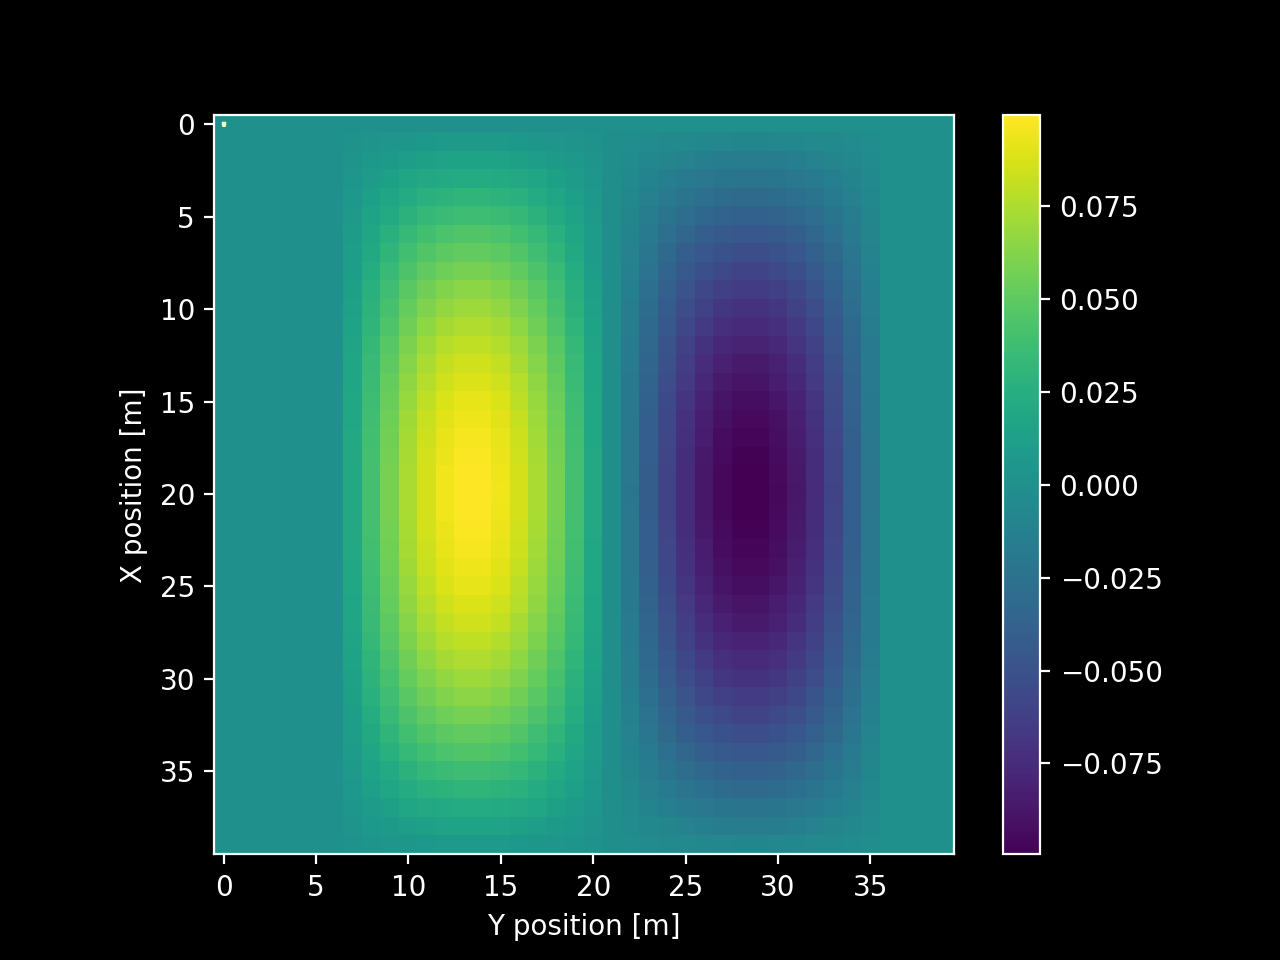

In [8]:
set_one_wave(e_field, h_field, f, Nx, Ny, dx, dy, amplitude)
show_e_field(e_field)

# Numpy Implementation

In [35]:
# set_one_wave(e_field, h_field, f, Nx, Ny, dx, dy, amplitude)
for k, t in tqdm(enumerate(t_arr)):
    ez_result[k] = e_field
    # calc Ez
    e_field[2:-1, 2:-1, 0] = (c_ez[2:-1, 2:-1, 0] * e_field[2:-1, 2:-1, 0]) - c_ezly[2:-1, 2:-1, 0] * (h_field[2:-1, 2:-1, 0] - h_field[2:-1, 1:-2, 0]) \
    + c_ezlx[2:-1, 2:-1, 0] * (h_field[2:-1, 2:-1, 1] - h_field[1:-2, 2:-1, 1]) 
    # current source
    e_field = e_field -  jz_t[k,:,:,:]
    # calc Hx
    h_field[1:-1, 0:-1, 0] = h_field[1:-1, 0:-1, 0] - c_hxly[1:-1, 0:-1, 0] * (e_field[1:-1, 1:, 0]  - e_field[1:-1, 0:-1, 0])
    # calc Hy
    h_field[0:-1, 1:-1, 1] = h_field[0:-1, 1:-1, 1] + c_hxly[0:-1, 1:-1, 0] * (e_field[1:, 1:-1, 0]  - e_field[0:-1, 1:-1, 0])
print(np.average(np.sqrt((e_field**2))))

1000it [00:00, 6374.62it/s]

0.0007427773819963661


# Slow Implementation

In [ ]:
for k, t in tqdm(enumerate(t_arr)):
    ez_result[k] = e_field
    # calc Ez
    for i  in range(2,Nx-1):
        for j  in range(2,Ny-1):
            e_field[i, j] = c_ez[i, j] * e_field[i,j] - c_ezly[i,j]*(h_field[i,j,0] - h_field[i,j-1,0])  \
            + c_ezlx[i,j]*(h_field[i,j,1] - h_field[i-1,j,1])
    # e_field
    # print(e_field[ex_x-1:ex_x+2,ex_y-1:ex_y+2])
    # calc Hx
    for i  in range(1, Nx - 1):
        for j  in range(0, Ny - 1):
            h_field[i,  j, 0] = h_field[i,  j, 0] - c_hxly[i, j] * (e_field[i, j+1] - e_field[i, j])
    # calc Hy
    for i  in range(0, Nx - 1):
        for j  in range(1, Ny - 1):
            h_field[i,  j, 1] = h_field[i,  j, 1] + c_hxlx[i, j] * (e_field[i+1, j] - e_field[i, j])
    #plt.plot(t_arr, ez_val)
print(np.average(np.sqrt((e_field**2))))

# 3D graph

In [36]:
X = np.linspace(0, Nx*dx, Nx, endpoint=False)
Y = np.linspace(0, Ny*dy, Ny, endpoint=False)
X, Y = np.meshgrid(X, Y)

In [38]:
def animate(i):
    fig = plt.figure()
    fig.set_dpi(100)
    ax = Axes3D(fig)
    ax.clear()
    ax.plot_surface(X, Y, ez_result[i*frame_step,:,:,0].transpose(), rstride=1, cstride=1, cmap=plt.cm.coolwarm,vmax=0.2,vmin=-0.2)
    ax.set_zlim(-0.2, 0.2)

<IPython.core.display.Javascript object>


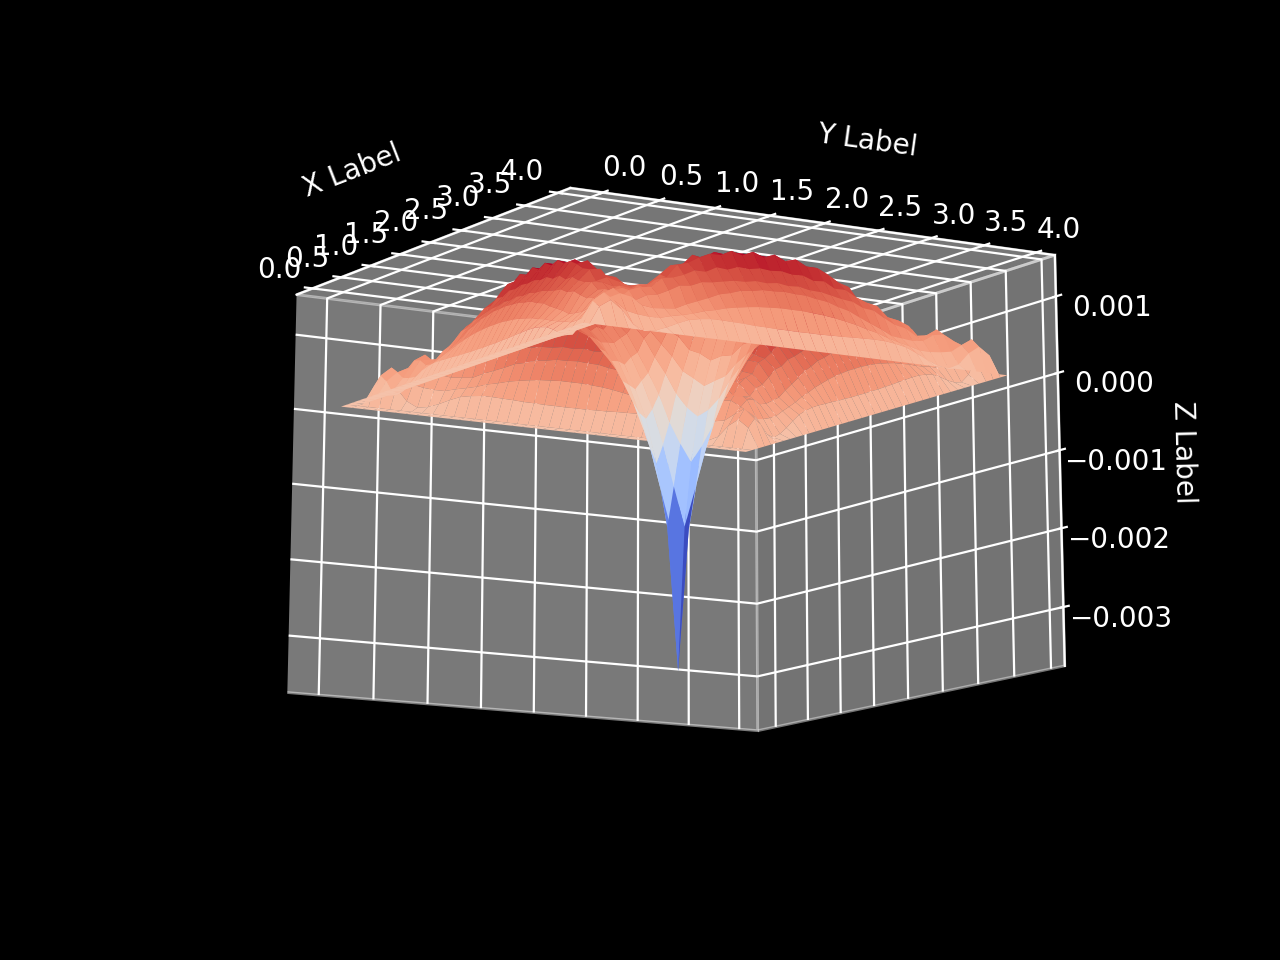

In [48]:
frame_step = 10
time_index = 10
fig = plt.figure()
# fig.set_dpi(100)
ax = fig.add_subplot(111, projection='3d')
ax.clear()
ax.plot_surface(X, Y, ez_result[time_index*frame_step,:,:,0].transpose(), rstride=1, cstride=1, cmap=plt.cm.coolwarm)
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
fig.show()

In [ ]:
fig = plt.figure()
# fig.set_dpi(100)
ax = fig.add_subplot(111, projection='3d')
ax.clear()
ax.plot_surface(X, Y, ez_result[4*frame_step,:,:,0], rstride=10, cstride=10, cmap=plt.cm.coolwarm,vmax=0.2,vmin=-0.2)
ax.set_zlim(-0.2, 0.2)

In [ ]:

# plt.show()
nt = t_arr.shape[0]
frame_end = int(np.floor(nt/10))
anim3d = animation.FuncAnimation(fig,animate,frames=frame_end,interval=10,repeat=False)
anim3d.save("wave2D-N2.gif", writer="imagemagick")

In [ ]:
anim.save("wave2D-Nhoge.gif", writer="imagemagick")

# 2D Animation

In [41]:
def gen_2d_animation(filename, ez_result, step=1, end=-1):
    fig = plt.figure()
    ims = []
    if end == -1:
        end = ez_result.shape[0]
    for k in range(0, end, step):
        im = plt.imshow(ez_result[k,:,:,0], animated=True)
        ims.append([im])

    ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)
    ani.save('{}.gif'.format(filename), writer="imagemagick")
    plt.show()


<IPython.core.display.Javascript object>


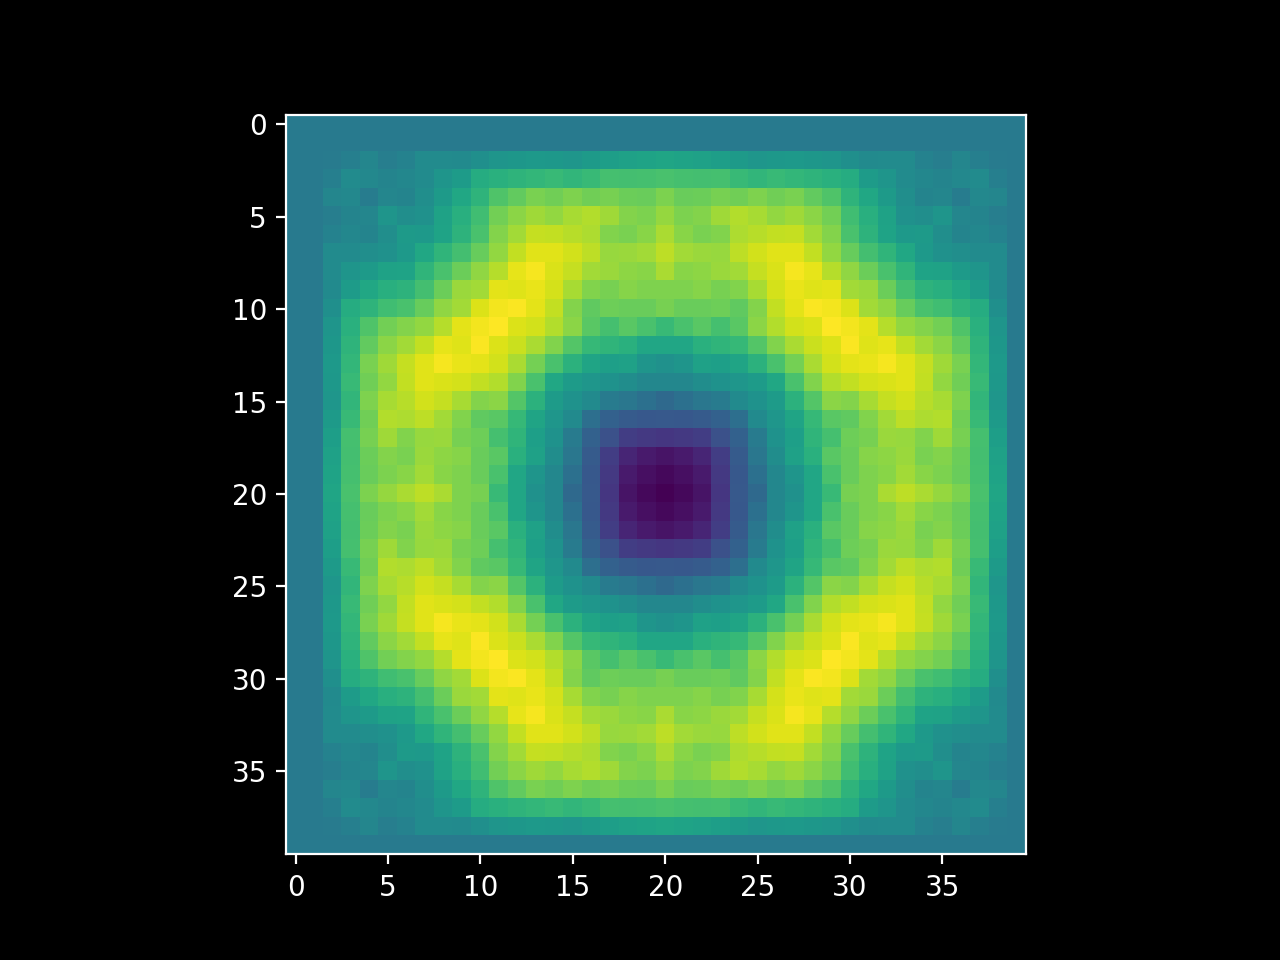

In [43]:
gen_2d_animation("pulse_simulation", ez_result, step=1)